<center><h1>1-e: Transformers</h1></center>
<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>


# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.

In this notebook, we will implement the first Visual Transformer, [ViT](https://arxiv.org/abs/2010.11929). We'll implement a naive version of it, much smaller than the ones described in the paper, and we also won't use complex data augmentation and regularizations. But note that this is important to make transformers work in practice on large-scale dataset.

To get a gist of what is required to make a transformer work in practice, have a look at the [DeiT and CaiT codebase](https://github.com/facebookresearch/deit).

This notebook is a simplified version of the excellent [Timm library](https://github.com/rwightman/pytorch-image-models).

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pickle
import math

import numpy as np
from tqdm import tqdm
from time import time
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

Let's load the MNIST dataset:

In [8]:
transform = transforms.Compose([
  transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

... and visualize!

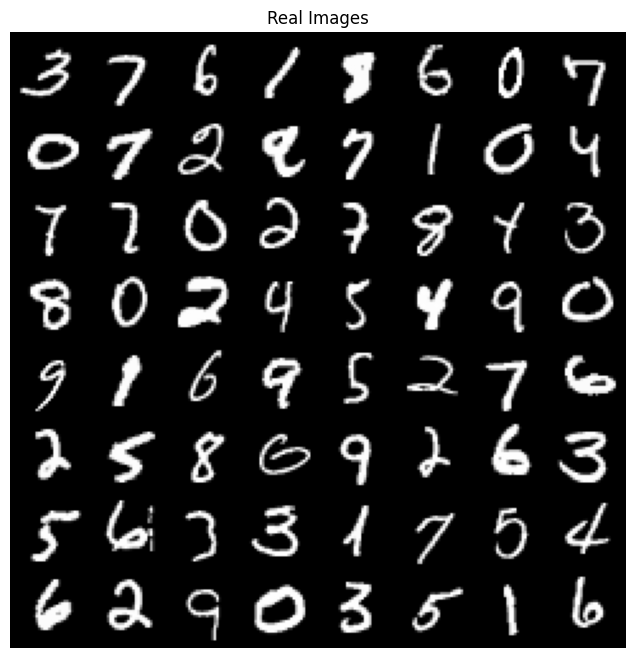

In [6]:

real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

# Here is the general architecture of the ViT model
## The architecture includes:
- A step for splitting the image into disjoint patches with a linear projection of the patches
- Positional encoding to capture the absolute spatial information of each patch in the image
- The addition of a "[CLS]" token, initialized randomly and learned during training
- A transformer encoder that learns the representation of each token
- A classification head that performs class prediction from the re-embedded [CLS] token at the output of the encoder

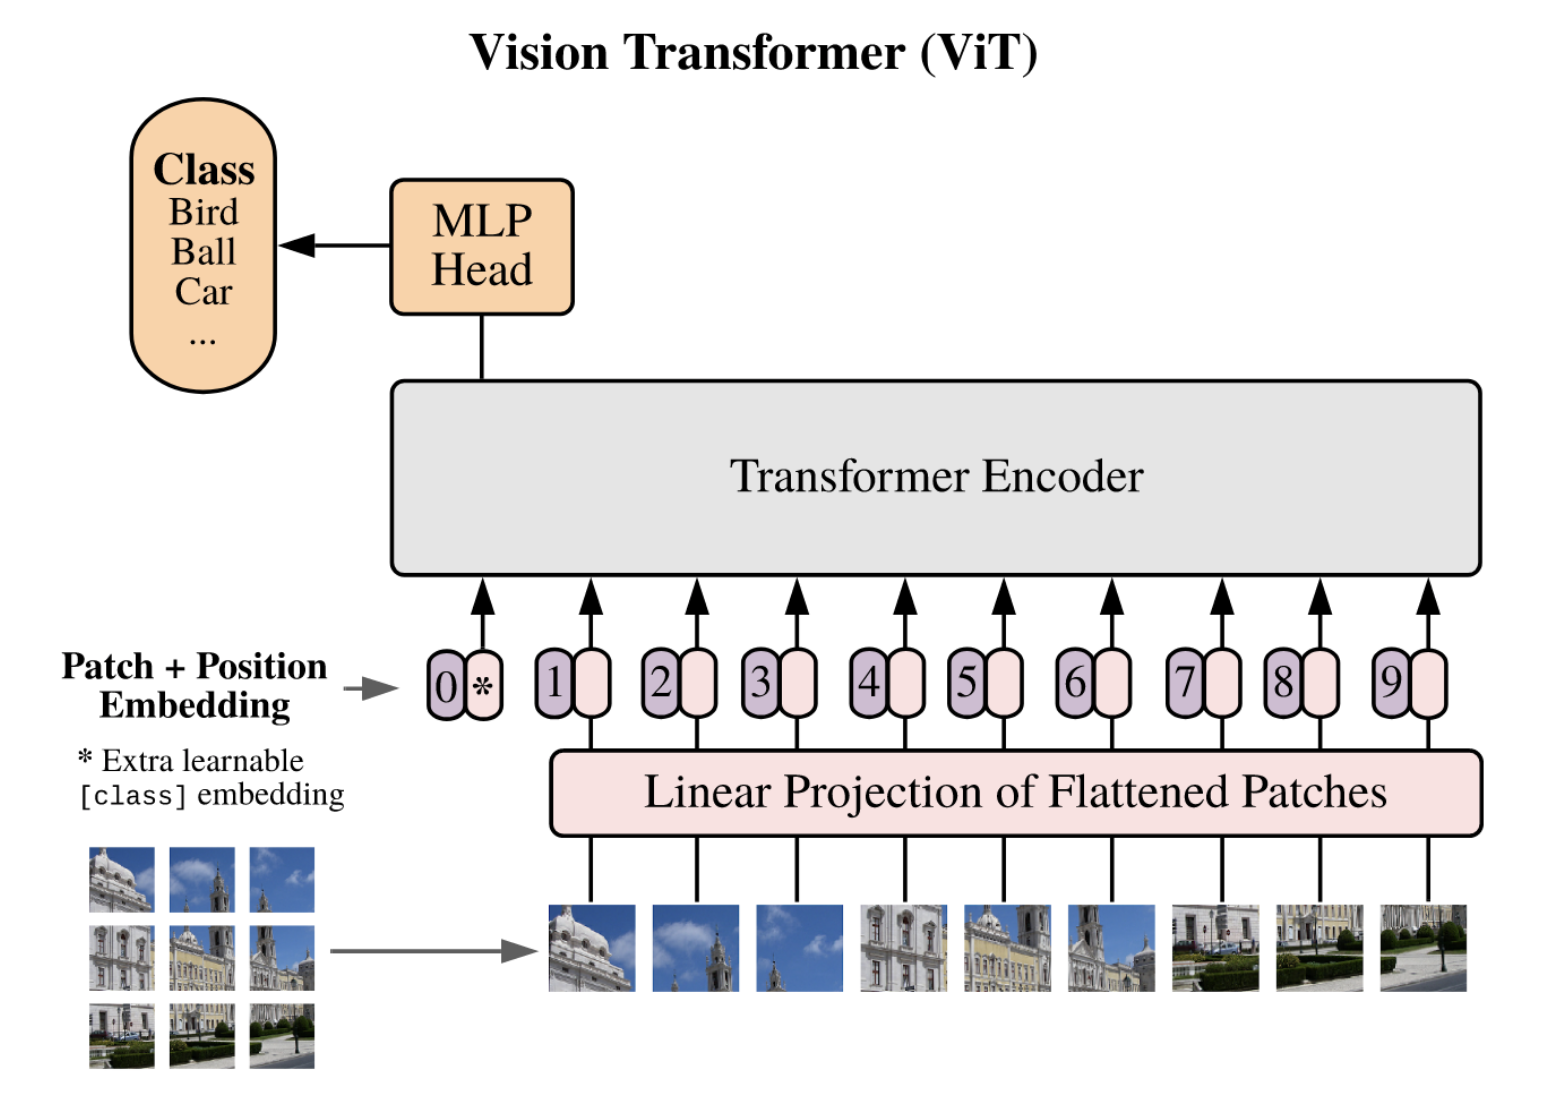

# Linear Projection of flattened patches

**Q1**:
First, we need to code the patch embedding. In NLP, it could be using a word2vec embeddings, but we need something different in Computer Vision.

You are going to use a specific 2d convolution to play the role of the so-called "Linear Projection" on the image above and process each patch independently without overlap. Think a bit how you could do that.

Then, you need to manipulate the dimensions of the resulting tensor to get a final tensor of shape `(batch_size, nb_tokens, embedding_dim)`. *Hint: You will need a `view/reshape` and `transpose/permute` operators*.

As usual, remember to check the output shape of your layer by trying with a random tensor!

In [7]:
class PatchEmbed(nn.Module):
    def __init__(self, in_chan=1,patch_size=7, embed_dim=128):
        super(PatchEmbed, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        # Create a convolutional layer for patch embedding
        self.projection = nn.Conv2d(in_chan, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        image_size = x.size(2)

        # Apply to a batch of images the convolutional layer for patch embedding
        x = self.projection(x)

        # reshape
        x = x.view(x.size(0), -1, self.embed_dim)  # (batch_size, num_patches, embedding_dim)

        return x

In [8]:
channels = 1
patch_size = 7
embedding_dim = 64
PE = PatchEmbed(channels,patch_size,embedding_dim)
for x , y in train_loader:
  print(PE(x).size())
  break

torch.Size([128, 16, 64])


# Transformer encoder

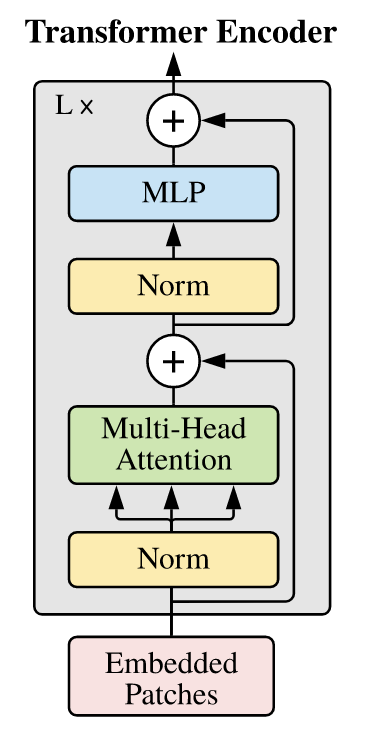

## Q2: MLP

Now we need to build a transformer block. Let's first build the easiest part, the MLP! By now, you should be confident how to code one.

Code a MLP with one hidden layer. Note that the input and output dimensions will be the same. Instead of ReLU, use the activation GELU, which is a slight alternative often used for transformers.

In [9]:
class MLP(nn.Module):
  def __init__(self, in_features, hid_features):
    super().__init__()
    self.in_features = in_features
    self.hid_features = hid_features
    self.mlp = nn.Sequential(
        nn.Linear(self.in_features , self.hid_features),
        nn.GELU(),
        nn.Linear(self.hid_features , self.in_features)
    )
  def forward(self, x):
    return self.mlp(x)

MLP(128, 512)(torch.randn(32, 16, 128)).size()

torch.Size([32, 16, 128])

## Q3: Self-attention

Now we are going to build the famous **Self-Attention**.
- What is the main feature of self-attention, especially compared to its convolutional counterpart. What is its main challenge in terms of computation/memory?
- At first, we are going to only consider the simple case of one head. Write the equations and complete the following code. And don't forget a final linear projection at the end!




In [10]:
class SelfAttention(nn.Module):
  def __init__(self,embed_dim):
    super().__init__()

    self.embed_dim = embed_dim

    # if the attention_dim is not given in the __init__()
    # generally the attention dimension is 'much' smaller that the embedded dim
    # self.attention_dim = embed_dim // 2

    # because we have only one head attention
    self.attention_dim = embed_dim

    # create a dense layer to compute Q,K,V matrix
    # input ---> X(batch_size,number_patchs,embbed_dim)
    # output ---> Xhat(batch_size,number_patchs,attention_dim)
    self.dense_layer_Q = nn.Linear(self.embed_dim , self.attention_dim,bias=False)
    self.dense_layer_K = nn.Linear(self.embed_dim , self.attention_dim,bias=False)
    self.dense_layer_V = nn.Linear(self.embed_dim , self.attention_dim,bias=False)

    # input ---> X(batch_size,number_patchs,attention_dim)
    # output ---> Xhat(batch_size,number_patchs,attention_dim)
    self.dense_layer_final_projection = nn.Linear(self.attention_dim , self.attention_dim,bias=True)

    # just to do a scaling on the attention matrix
    # Attention / sqrt(attention_dim)   <----> Attention *  attention_dim** (-0.5)
    self.scale = self.attention_dim ** -0.5

    # define the softmax module
    # the softmax is taken across rows and not columns (which wouldn’t be meaningful).
    self.softmax_scores = nn.Softmax(dim=-1)

  def forward(self, x):
    Batch_size,number_patchs,embedded_dim = x.size()

    # TODO: compute the Q, K, V
    q = self.dense_layer_Q(x)
    k = self.dense_layer_K(x)
    v = self.dense_layer_V(x)

    # TODO: compute the attention matrix using Q and K
    attention = torch.matmul(q,k.transpose(-1,-2))
    # scaling the attention matrix
    attention = attention * self.scale

    # softmax the attention
    softmax_attention = self.softmax_scores(attention)

    # compute the final version using the attention,
    # V, and the final projection
    H = torch.matmul(softmax_attention , v)

    # the final projection
    final_projection = self.dense_layer_final_projection(H)

    return final_projection


SelfAttention(embed_dim=128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q4 : Multi-head self-attention

Now we need to build a Multi-Heads Self-Attention.
- Write the equations and complete the following code to build a Multi-Heads Self-Attention.
- The total embedding size will be shared equally among all heads.

In [11]:
class MultiHeadsSelfAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()


    if embed_dim // num_heads != embed_dim / num_heads : raise Exception("Warning : Emebdding dimension and number of heads are not compatible")
    self.head_dim = embed_dim // num_heads
    self.embed_dim = embed_dim

    self.scale = self.head_dim ** -0.5
    self.num_heads = num_heads


    # create a dense layer to compute Q,K,V matrix
    # input ---> X(batch_size,number_patchs,embbed_dim)
    # output ---> Xhat(batch_size,number_patchs,attention_dim)
    self.dense_layer_Q = nn.Linear(self.embed_dim , self.embed_dim,bias=False)
    self.dense_layer_K = nn.Linear(self.embed_dim , self.embed_dim,bias=False)
    self.dense_layer_V = nn.Linear(self.embed_dim , self.embed_dim,bias=False)

    # input ---> X(batch_size,number_patchs,embed_dim)
    # output ---> Xhat(batch_size,number_patchs,embed_dim)
    self.dense_layer_final_projection = nn.Sequential(
        nn.Linear(self.embed_dim , self.embed_dim,bias=True),
        nn.Dropout(0.3)
    )

    # define the softmax module
    # the softmax is taken across rows and not columns (which wouldn’t be meaningful).
    self.softmax_scores = nn.Softmax(dim=-1)

  def forward(self, x):
    batch_size,number_patchs,embedded_dim = x.size()

    q = self.dense_layer_Q(x)
    k = self.dense_layer_K(x)
    v = self.dense_layer_V(x)


    # You need to reshape and permute dimension in a certain manner
    # so that each head (C // num_heads) interact
    # only with its dimensions and not other heads.

    # Splitting Q, K, and V into their heads
    # from embed_dim ---> (num_heads , head_dim)
    # transpose number_patchs and num_heads
    # each sequence is split across num_heads, with each head receiving number_patchs patchs with head_dim elements.
    q = q.view(batch_size,-1,self.num_heads,self.head_dim).permute(0,2,1,3)
    k = k.view(batch_size,-1,self.num_heads,self.head_dim).permute(0,2,1,3)
    v = v.view(batch_size,-1,self.num_heads,self.head_dim).permute(0,2,1,3)
    # print(q.size())
    # print(k.size())
    # print(v.size())

    # TODO: compute the attention matrix using Q and K
    attention = torch.matmul(q,k.transpose(-1,-2))
    # scaling the attention matrix
    attention = attention * self.scale

    # softmax the attention
    softmax_attention = self.softmax_scores(attention)

    # compute the final version using the attention,
    # V, and the final projection
    H = torch.matmul(softmax_attention , v)

    ''' At this point, the heads can be concatenated back together before they are passed through
        the final linear layer'''
    ''' The concatenation reverses the split that was performed originally. The first step is to transpose num_heads and number_patchs.
        The second step is to concatenate num_heads and head_dim back together to get embed_dim.'''
    ''' Once this is complete, A will have a shape of (batch_size, number_patchs, embed_dim).'''


    # guarantee that the tensor has a continuous memory layout otherwise the reshape will not work
    H = H.permute(0,2,1,3).contiguous()

    H = H.view(batch_size,-1,self.num_heads*self.head_dim)

    final_projection = self.dense_layer_final_projection(H)

    return final_projection


MultiHeadsSelfAttention(128,8)(torch.randn(32, 16, 128)).size()

torch.Size([32, 16, 128])

# Q5: Transfomer block

Now, we need to build a Transformer **Block** as described in the image below.
- Write the equations and complete the following code.
- For the Layer Normalization, use PyTorch LayerNorm: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

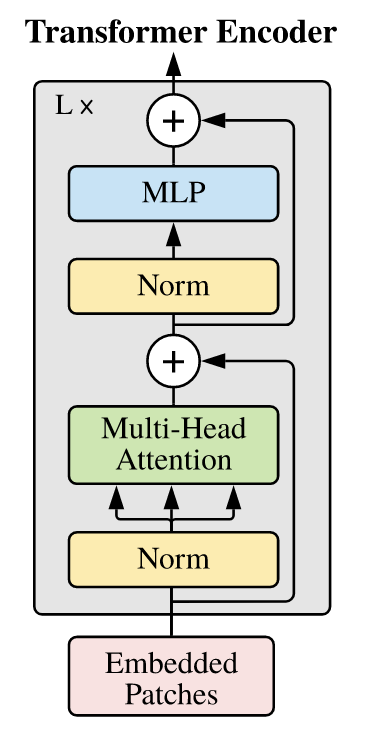

In [12]:
class Block(nn.Module):
  def __init__(self, embed_dim, num_heads=4, mlp_ratio=4):
    super().__init__()

    self.embed_dim = embed_dim
    self.num_heads = num_heads
    # self.Norm = nn.LayerNorm()
    self.MHSA = MultiHeadsSelfAttention(self.embed_dim,self.num_heads)

    dim_hid = self.embed_dim * mlp_ratio
    self.MLP = MLP(self.embed_dim,dim_hid)

    # define the norm layer
    # the normlisation only on embedded_dim ( i'm not sure !!!! )
    self.cudalayer_norm = nn.LayerNorm([self.embed_dim])

  def forward(self, x):

    batch_size,number_patchs,embedded_dim = x.size()

    # define the embedded_patches
    embedded_patches = x

    # get the normalized embedded patches
    embedded_patches_norm = self.cudalayer_norm(embedded_patches)

    # pass the the normalized embedded patches on the MHSA
    embedded_patches_norm_MHSA = self.MHSA(embedded_patches_norm)

    # the first sub block
    first_sub_block_output = embedded_patches_norm_MHSA + embedded_patches

    # normalize the first sub block output
    first_sub_block_output_norm = self.cudalayer_norm(first_sub_block_output)

    # Apply the MLP layer
    first_sub_block_output_norm_MLP = self.MLP(first_sub_block_output_norm)

    # the second sub block
    second_sub_block_output = first_sub_block_output + first_sub_block_output_norm_MLP

    return second_sub_block_output

Block(embed_dim=128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q6: Full ViT model

Now you need to build a ViT model based on what you coded in the previous questions. There are additional components that should be coded such as the Class token, Positional embedding and the classification head.

- Explain what is a Class token and why we use it? \\
- Explain whay is the the positional embedding (PE) and why it is important? \\

For PE, you can use a sinusoidal encoding (see below), or fully learned.


### Sinusoidal PE


In [13]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(1,sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[0][i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [14]:
class ViT(nn.Module):
  def __init__(self, embed_dim, nb_blocks, patch_size, nb_classes=10):
    super().__init__()
    self.embed_dim = embed_dim
    self.nb_blocks = nb_blocks
    self.patch_size = patch_size

    num_patches = (28 // patch_size) ** 2


    self.cls_token = nn.Parameter(torch.rand(1, 1, embed_dim))
    # + 1 --> for CLS token
    self.pos_embed = nn.Parameter(get_positional_embeddings(num_patches+1,self.embed_dim))
    self.pos_embed.requires_grad = False
    self.patch_embed = PatchEmbed(in_chan=1 , patch_size=self.patch_size, embed_dim=self.embed_dim)

    blocks = []
    for _ in range(nb_blocks):
      blocks.append(
          Block(self.embed_dim)
      )
    self.blocks = nn.Sequential(*blocks)

    self.norm = nn.LayerNorm(self.embed_dim)
    self.head = nn.Sequential(
      nn.Linear(self.embed_dim,nb_classes),
      nn.Softmax(dim=-1)
    )

  def forward(self, x):

    # image to patches
    embedded_patches = self.patch_embed(x)
    batch_size , number_patches , embedding_dim = embedded_patches.size()

    # add the CLS token
    cls_tokens = self.cls_token.expand(batch_size, -1, -1)
    # self.class_token = torch.randn(batch_size ,1,self.embed_dim)

    # concatenating class token
    embedded_patches = torch.cat([cls_tokens ,embedded_patches],dim=1)

    # define the positional embedding
    pos_embed = self.pos_embed.repeat(batch_size, 1, 1)

    # adding positional embedding
    embedded_patches = embedded_patches + pos_embed

    ## forward in the transformer
    embedded_patches_hat = self.blocks(embedded_patches)


    ## Normalize the output
    embedded_patches_hat_norm = self.norm(embedded_patches_hat)

    # head MLP : classification output
    # to do classification we only need the CLS vector
    output = self.head(embedded_patches_hat_norm[:,0,:])
    # output = self.head(embedded_patches_hat_norm.mean)
    return output

ViT(128, 3, 7)(torch.randn(32, 1, 28, 28)).shape

torch.Size([32, 10])

# Q7: Experiment on MNIST!

A quick function to evaluate our model:

In [15]:
@torch.no_grad()
def eval_model(model, loader):
  model.eval()
  acc = 0.
  c = 0
  losses = 0
  n = 0

  for x, y in loader:
    x, y = x, y
    yhat = model(x)

    loss = F.cross_entropy(yhat, y)

    losses += loss.item()
    n += 1

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(acc / c, 2) , round(losses/n , 2)

And run! Feel free to try other hyperparameters.

In [ ]:
epochs = 2

embed_dim = 32
patch_size = 7
nb_blocks = 2
learning_rate = 1e-2

model = ViT(embed_dim, nb_blocks, patch_size)


opt = torch.optim.Adam(model.parameters(),lr=learning_rate)
from time import time
from tqdm import tqdm
tac = time()
for epoch in tqdm(range(epochs)):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x, y

    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc , loss_test = eval_model(model, test_loader)
print(f"Test accuracy: {acc}")
print(f"Test loss: {loss_test}")

tic = time()
print(f"{round((tic-tac)/60 , 2)} min")


 50%|█████     | 1/2 [00:31<00:31, 31.55s/it]

--- Epoch 0 ---
Train loss: 1.6719875833881435


100%|██████████| 2/2 [00:57<00:00, 28.57s/it]

--- Epoch 1 ---
Train loss: 1.571926804747917


Test accuracy: 0.91
Test loss: 1.55
0.99 min


# Experimental analysis
- Test different hyperparameters and explain how they affect the performance. In particular embed_dim, patch_size, and nb_blocks.
- Comment and discuss the final performance that you get. How to improve it?
-  What is the complexity of the transformer in terms of number of tokens? How you can improve it?

## Experimentation on Embedded dimension

In [22]:
epochs = 4

embed_dims = [16,32,64,96]
patch_size = 7
nb_blocks = 2
learning_rate = 1e-2

from time import time

train_per_model = []
test_per_model = []
time_per_model = []
for embed_dim in tqdm(embed_dims):
  tac = time()
  model = ViT(embed_dim, nb_blocks, patch_size)
  opt = torch.optim.Adam(model.parameters(),lr=learning_rate)
  train_acc_per_epoch = []
  test_acc_per_epoch = []
  train_loss_per_epoch = []
  test_loss_per_epoch = []
  for epoch in range(epochs):
    train_loss = 0.
    acc = 0.
    c = 0
    for x, y in train_loader:
      x, y = x, y

      opt.zero_grad()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      loss.backward()

      opt.step()

      train_loss += loss.item()

      acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
      c += len(x)

    print(f"\n--- Epoch {epoch} ---")

    print(f"Train loss: {train_loss / len(train_loader)}")
    print(f"Train accuracy : {round(acc/c , 2)}")
    train_acc_per_epoch.append(round(acc/c , 2))
    train_loss_per_epoch.append(train_loss / len(train_loader))

    acc_test , loss_test = eval_model(model, test_loader)
    print(f"Test loss: {loss_test}")
    print(f"Test accuracy : {acc_test}")
    print()
    test_acc_per_epoch.append(acc_test)
    test_loss_per_epoch.append(loss_test)

  tic = time()
  time_spent = round((tic-tac)/60 , 2)
  train_per_model.append((train_acc_per_epoch,train_loss_per_epoch))
  test_per_model.append((test_acc_per_epoch,test_loss_per_epoch))
  time_per_model.append(time_spent)

  0%|          | 0/4 [00:00<?, ?it/s]


--- Epoch 0 ---
Train loss: 1.7090868019600158
Train accuracy : 0.76
Test loss: 1.59
Test accuracy : 0.87


--- Epoch 1 ---
Train loss: 1.5947464150406405
Train accuracy : 0.87
Test loss: 1.57
Test accuracy : 0.89


--- Epoch 2 ---
Train loss: 1.585642050578396
Train accuracy : 0.88
Test loss: 1.55
Test accuracy : 0.91


--- Epoch 3 ---
Train loss: 1.574633691102457
Train accuracy : 0.89


 25%|██▌       | 1/4 [01:09<03:27, 69.20s/it]

Test loss: 1.55
Test accuracy : 0.91


--- Epoch 0 ---
Train loss: 1.6787720613642287
Train accuracy : 0.79
Test loss: 1.57
Test accuracy : 0.89


--- Epoch 1 ---
Train loss: 1.5871078800290888
Train accuracy : 0.87
Test loss: 1.55
Test accuracy : 0.91


--- Epoch 2 ---
Train loss: 1.5705700586599582
Train accuracy : 0.89
Test loss: 1.56
Test accuracy : 0.91


--- Epoch 3 ---
Train loss: 1.5611773381101044
Train accuracy : 0.9


 50%|█████     | 2/4 [02:29<02:31, 75.53s/it]

Test loss: 1.55
Test accuracy : 0.91


--- Epoch 0 ---
Train loss: 1.8232635086787534
Train accuracy : 0.64
Test loss: 1.7
Test accuracy : 0.76


--- Epoch 1 ---
Train loss: 1.695340211457535
Train accuracy : 0.77
Test loss: 1.66
Test accuracy : 0.8


--- Epoch 2 ---
Train loss: 1.6762683437323012
Train accuracy : 0.78
Test loss: 1.84
Test accuracy : 0.62


--- Epoch 3 ---
Train loss: 1.7034116991039023
Train accuracy : 0.76


 75%|███████▌  | 3/4 [05:50<02:13, 133.10s/it]

Test loss: 1.66
Test accuracy : 0.8


--- Epoch 0 ---
Train loss: 1.84880325306199
Train accuracy : 0.61
Test loss: 1.74
Test accuracy : 0.72


--- Epoch 1 ---
Train loss: 1.7315205086523027
Train accuracy : 0.73
Test loss: 1.63
Test accuracy : 0.83


--- Epoch 2 ---
Train loss: 1.6050391499675922
Train accuracy : 0.86
Test loss: 1.56
Test accuracy : 0.9


--- Epoch 3 ---
Train loss: 1.573506289199471
Train accuracy : 0.89


100%|██████████| 4/4 [12:28<00:00, 187.18s/it]

Test loss: 1.57
Test accuracy : 0.9



In [23]:
print(train_per_model)
print()
print(test_per_model)
print()
print(time_per_model)

[([0.76, 0.87, 0.88, 0.89], [1.7090868019600158, 1.5947464150406405, 1.585642050578396, 1.574633691102457]), ([0.79, 0.87, 0.89, 0.9], [1.6787720613642287, 1.5871078800290888, 1.5705700586599582, 1.5611773381101044]), ([0.64, 0.77, 0.78, 0.76], [1.8232635086787534, 1.695340211457535, 1.6762683437323012, 1.7034116991039023]), ([0.61, 0.73, 0.86, 0.89], [1.84880325306199, 1.7315205086523027, 1.6050391499675922, 1.573506289199471])]

[([0.87, 0.89, 0.91, 0.91], [1.59, 1.57, 1.55, 1.55]), ([0.89, 0.91, 0.91, 0.91], [1.57, 1.55, 1.56, 1.55]), ([0.76, 0.8, 0.62, 0.8], [1.7, 1.66, 1.84, 1.66]), ([0.72, 0.83, 0.9, 0.9], [1.74, 1.63, 1.56, 1.57])]

[1.15, 1.33, 3.36, 6.63]


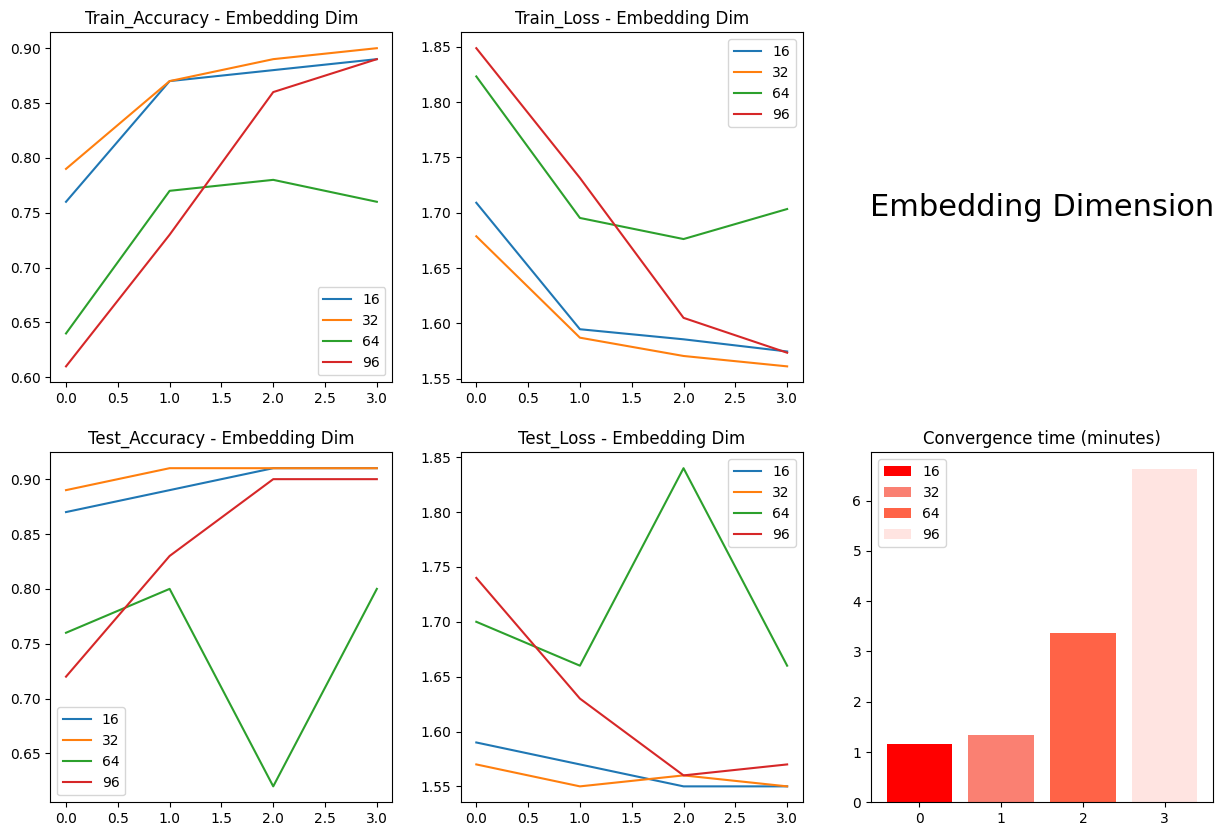

In [24]:
plt.figure(figsize=(15,10))

plt.subplot(231)
for i in range(len(embed_dims)):
  plt.plot(range(epochs),train_per_model[i][0],label=embed_dims[i])

plt.title("Train_Accuracy - Embedding Dim")
plt.legend()

plt.subplot(232)
for i in range(len(embed_dims)):
  plt.plot(range(epochs),train_per_model[i][1],label=embed_dims[i])

plt.title("Train_Loss - Embedding Dim")
plt.legend()

plt.subplot(233)
plt.axis('off')
plt.text(0.5, 0.5,'Embedding Dimension', ha='center', va='center', fontsize=22, color='black')

plt.subplot(234)
for i in range(len(embed_dims)):
  plt.plot(range(epochs),test_per_model[i][0],label=embed_dims[i])

plt.title("Test_Accuracy - Embedding Dim")
plt.legend()

plt.subplot(235)
for i in range(len(embed_dims)):
  plt.plot(range(epochs),test_per_model[i][1],label=embed_dims[i])

plt.title("Test_Loss - Embedding Dim")
plt.legend()

plt.subplot(236)
plt.title("Convergence time (minutes)")
plt.bar(range(epochs),time_per_model,label=embed_dims,color=['red','salmon','tomato','mistyrose'])
plt.legend()


plt.savefig('Embedding_dimension.png', dpi=300)
plt.show()

## Experimentation on Patch Size

In [25]:
epochs = 4

embed_dim = 32
patch_sizes = [4,7,14]
nb_blocks = 2
learning_rate = 1e-2

train_per_model = []
test_per_model = []
time_per_model = []
for patch_size in tqdm(patch_sizes):
  tac = time()
  model = ViT(embed_dim, nb_blocks, patch_size)
  opt = torch.optim.Adam(model.parameters(),lr=learning_rate)
  train_acc_per_epoch = []
  test_acc_per_epoch = []
  train_loss_per_epoch = []
  test_loss_per_epoch = []
  for epoch in range(epochs):
    train_loss = 0.
    acc = 0.
    c = 0
    for x, y in train_loader:
      x, y = x, y

      opt.zero_grad()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      loss.backward()

      opt.step()

      train_loss += loss.item()

      acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
      c += len(x)

    print(f"\n--- Epoch {epoch} ---")

    print(f"Train loss: {train_loss / len(train_loader)}")
    print(f"Train accuracy : {round(acc/c , 2)}")
    train_acc_per_epoch.append(round(acc/c , 2))
    train_loss_per_epoch.append(train_loss / len(train_loader))

    acc_test , loss_test = eval_model(model, test_loader)
    print(f"Test loss: {loss_test}")
    print(f"Test accuracy : {acc_test}")
    print()
    test_acc_per_epoch.append(acc_test)
    test_loss_per_epoch.append(loss_test)

  tic = time()
  time_spent = round((tic-tac)/60 , 2)
  train_per_model.append((train_acc_per_epoch,train_loss_per_epoch))
  test_per_model.append((test_acc_per_epoch,test_loss_per_epoch))
  time_per_model.append(time_spent)

  0%|          | 0/3 [00:00<?, ?it/s]


--- Epoch 0 ---
Train loss: 1.7544387726387236
Train accuracy : 0.71
Test loss: 1.59
Test accuracy : 0.87


--- Epoch 1 ---
Train loss: 1.5921146856950545
Train accuracy : 0.87
Test loss: 1.59
Test accuracy : 0.87


--- Epoch 2 ---
Train loss: 1.5728937494221018
Train accuracy : 0.89
Test loss: 1.56
Test accuracy : 0.9


--- Epoch 3 ---
Train loss: 1.5610974106961475
Train accuracy : 0.9


 33%|███▎      | 1/3 [03:16<06:32, 196.22s/it]

Test loss: 1.54
Test accuracy : 0.92


--- Epoch 0 ---
Train loss: 1.6595312595875786
Train accuracy : 0.8
Test loss: 1.55
Test accuracy : 0.91


--- Epoch 1 ---
Train loss: 1.5674364747269067
Train accuracy : 0.89
Test loss: 1.54
Test accuracy : 0.92


--- Epoch 2 ---
Train loss: 1.5523728536390293
Train accuracy : 0.91
Test loss: 1.54
Test accuracy : 0.92


--- Epoch 3 ---
Train loss: 1.5463425586981052
Train accuracy : 0.92


 67%|██████▋   | 2/3 [04:40<02:10, 130.21s/it]

Test loss: 1.54
Test accuracy : 0.92


--- Epoch 0 ---
Train loss: 1.6375415604760144
Train accuracy : 0.83
Test loss: 1.56
Test accuracy : 0.9


--- Epoch 1 ---
Train loss: 1.5689395978760872
Train accuracy : 0.89
Test loss: 1.54
Test accuracy : 0.92


--- Epoch 2 ---
Train loss: 1.5582853070200124
Train accuracy : 0.9
Test loss: 1.54
Test accuracy : 0.92


--- Epoch 3 ---
Train loss: 1.5547977152155406
Train accuracy : 0.91


100%|██████████| 3/3 [05:42<00:00, 114.20s/it]

Test loss: 1.53
Test accuracy : 0.93



In [26]:
print(train_per_model)
print()
print(test_per_model)
print()
print(time_per_model)

[([0.71, 0.87, 0.89, 0.9], [1.7544387726387236, 1.5921146856950545, 1.5728937494221018, 1.5610974106961475]), ([0.8, 0.89, 0.91, 0.92], [1.6595312595875786, 1.5674364747269067, 1.5523728536390293, 1.5463425586981052]), ([0.83, 0.89, 0.9, 0.91], [1.6375415604760144, 1.5689395978760872, 1.5582853070200124, 1.5547977152155406])]

[([0.87, 0.87, 0.9, 0.92], [1.59, 1.59, 1.56, 1.54]), ([0.91, 0.92, 0.92, 0.92], [1.55, 1.54, 1.54, 1.54]), ([0.9, 0.92, 0.92, 0.93], [1.56, 1.54, 1.54, 1.53])]

[3.27, 1.4, 1.04]


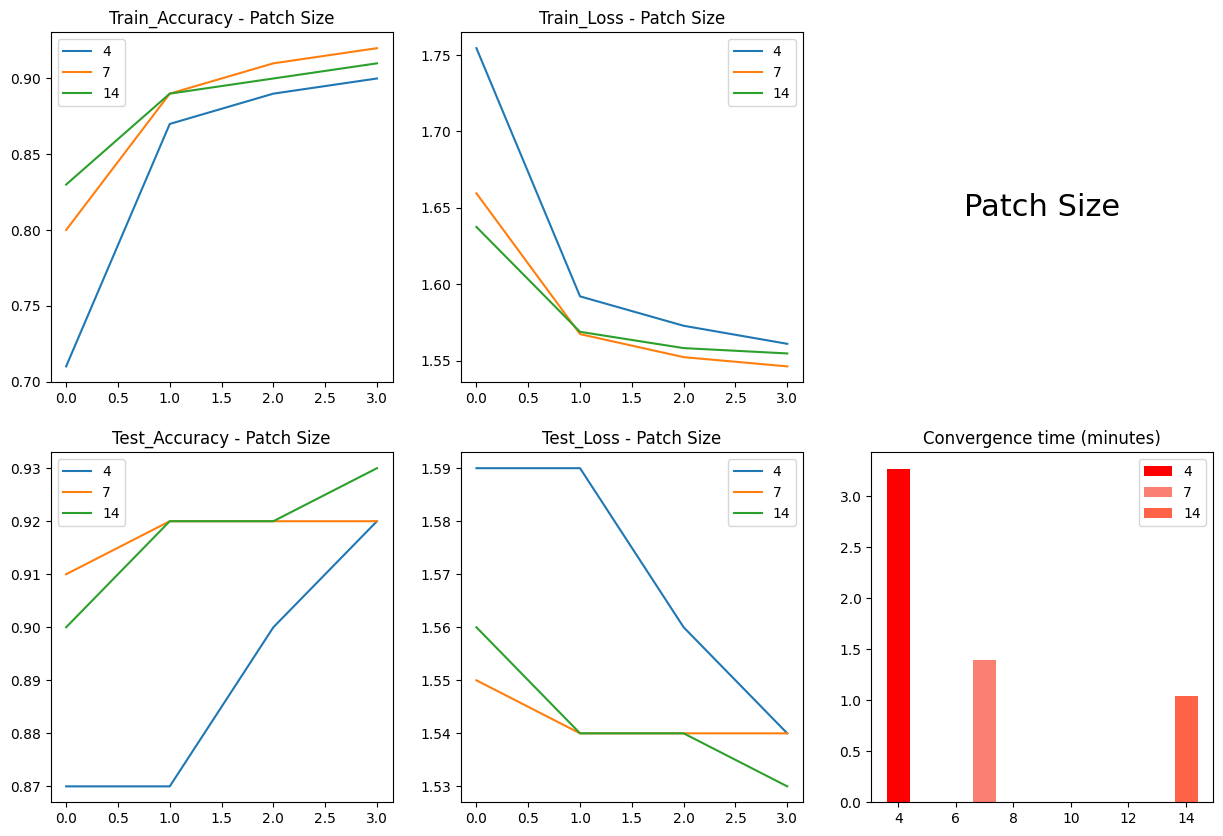

In [27]:
plt.figure(figsize=(15,10))

plt.subplot(231)
for i in range(len(patch_sizes)):
  plt.plot(range(epochs),train_per_model[i][0],label=patch_sizes[i])

plt.title("Train_Accuracy - Patch Size")
plt.legend()

plt.subplot(232)
for i in range(len(patch_sizes)):
  plt.plot(range(epochs),train_per_model[i][1],label=patch_sizes[i])

plt.title("Train_Loss - Patch Size")
plt.legend()

plt.subplot(233)
plt.axis('off')
plt.text(0.5, 0.5,'Patch Size', ha='center', va='center', fontsize=22, color='black')

plt.subplot(234)
for i in range(len(patch_sizes)):
  plt.plot(range(epochs),test_per_model[i][0],label=patch_sizes[i])

plt.title("Test_Accuracy - Patch Size")
plt.legend()

plt.subplot(235)
for i in range(len(patch_sizes)):
  plt.plot(range(epochs),test_per_model[i][1],label=patch_sizes[i])

plt.title("Test_Loss - Patch Size")
plt.legend()

plt.subplot(236)
plt.title("Convergence time (minutes)")
plt.bar(patch_sizes,time_per_model,label=patch_sizes,color=['red','salmon','tomato','mistyrose'])
plt.legend()


plt.savefig('patch_size.png', dpi=300)
plt.show()

## Experimentation on number of blocks

In [18]:
epochs = 4

embed_dim = 32
patch_sizes = 7
liste_nb_blocks = [2,3,4,5]
learning_rate = 1e-2

train_per_model = []
test_per_model = []
time_per_model = []
for nb_blocks in tqdm(liste_nb_blocks):
  tac = time()
  model = ViT(embed_dim, nb_blocks, patch_size)
  opt = torch.optim.Adam(model.parameters(),lr=learning_rate)
  train_acc_per_epoch = []
  test_acc_per_epoch = []
  train_loss_per_epoch = []
  test_loss_per_epoch = []
  for epoch in range(epochs):
    train_loss = 0.
    acc = 0.
    c = 0
    for x, y in train_loader:
      x, y = x, y

      opt.zero_grad()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      loss.backward()

      opt.step()

      train_loss += loss.item()

      acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
      c += len(x)

    print(f"\n--- Epoch {epoch} ---")

    print(f"Train loss: {train_loss / len(train_loader)}")
    print(f"Train accuracy : {round(acc/c , 2)}")
    train_acc_per_epoch.append(round(acc/c , 2))
    train_loss_per_epoch.append(train_loss / len(train_loader))

    acc_test , loss_test = eval_model(model, test_loader)
    print(f"Test loss: {loss_test}")
    print(f"Test accuracy : {acc_test}")
    print()
    test_acc_per_epoch.append(acc_test)
    test_loss_per_epoch.append(loss_test)

  tic = time()
  time_spent = round((tic-tac)/60 , 2)
  train_per_model.append((train_acc_per_epoch,train_loss_per_epoch))
  test_per_model.append((test_acc_per_epoch,test_loss_per_epoch))
  time_per_model.append(time_spent)

  0%|          | 0/4 [00:00<?, ?it/s]


--- Epoch 0 ---
Train loss: 1.705388528705914
Train accuracy : 0.76
Test loss: 1.59
Test accuracy : 0.87


--- Epoch 1 ---
Train loss: 1.5718883098061405
Train accuracy : 0.89
Test loss: 1.54
Test accuracy : 0.92


--- Epoch 2 ---
Train loss: 1.5568413528552187
Train accuracy : 0.9
Test loss: 1.53
Test accuracy : 0.93


--- Epoch 3 ---
Train loss: 1.5490925151910355
Train accuracy : 0.91


 25%|██▌       | 1/4 [01:20<04:01, 80.43s/it]

Test loss: 1.53
Test accuracy : 0.93


--- Epoch 0 ---
Train loss: 1.7166898952109981
Train accuracy : 0.75
Test loss: 1.57
Test accuracy : 0.89


--- Epoch 1 ---
Train loss: 1.5784321509952992
Train accuracy : 0.88
Test loss: 1.56
Test accuracy : 0.9


--- Epoch 2 ---
Train loss: 1.5600421260923212
Train accuracy : 0.9
Test loss: 1.54
Test accuracy : 0.93


--- Epoch 3 ---
Train loss: 1.552631760456923
Train accuracy : 0.91


 50%|█████     | 2/4 [03:07<03:11, 95.84s/it]

Test loss: 1.55
Test accuracy : 0.9


--- Epoch 0 ---
Train loss: 1.6901222698724092
Train accuracy : 0.78
Test loss: 1.56
Test accuracy : 0.9


--- Epoch 1 ---
Train loss: 1.5755136798439757
Train accuracy : 0.89
Test loss: 1.55
Test accuracy : 0.91


--- Epoch 2 ---
Train loss: 1.5617552100976646
Train accuracy : 0.9
Test loss: 1.56
Test accuracy : 0.9


--- Epoch 3 ---
Train loss: 1.5560920452004048
Train accuracy : 0.91


 75%|███████▌  | 3/4 [05:17<01:51, 111.59s/it]

Test loss: 1.54
Test accuracy : 0.92


--- Epoch 0 ---
Train loss: 1.7508329486033556
Train accuracy : 0.71
Test loss: 1.59
Test accuracy : 0.87


--- Epoch 1 ---
Train loss: 1.5948138908028349
Train accuracy : 0.87
Test loss: 1.57
Test accuracy : 0.89


--- Epoch 2 ---
Train loss: 1.5736409400317715
Train accuracy : 0.89
Test loss: 1.54
Test accuracy : 0.92


--- Epoch 3 ---
Train loss: 1.5640085790711424
Train accuracy : 0.9


100%|██████████| 4/4 [07:47<00:00, 116.98s/it]

Test loss: 1.55
Test accuracy : 0.91



In [19]:
print(train_per_model)
print()
print(test_per_model)
print()
print(time_per_model)

[([0.76, 0.89, 0.9, 0.91], [1.705388528705914, 1.5718883098061405, 1.5568413528552187, 1.5490925151910355]), ([0.75, 0.88, 0.9, 0.91], [1.7166898952109981, 1.5784321509952992, 1.5600421260923212, 1.552631760456923]), ([0.78, 0.89, 0.9, 0.91], [1.6901222698724092, 1.5755136798439757, 1.5617552100976646, 1.5560920452004048]), ([0.71, 0.87, 0.89, 0.9], [1.7508329486033556, 1.5948138908028349, 1.5736409400317715, 1.5640085790711424])]

[([0.87, 0.92, 0.93, 0.93], [1.59, 1.54, 1.53, 1.53]), ([0.89, 0.9, 0.93, 0.9], [1.57, 1.56, 1.54, 1.55]), ([0.9, 0.91, 0.9, 0.92], [1.56, 1.55, 1.56, 1.54]), ([0.87, 0.89, 0.92, 0.91], [1.59, 1.57, 1.54, 1.55])]

[1.34, 1.78, 2.17, 2.51]


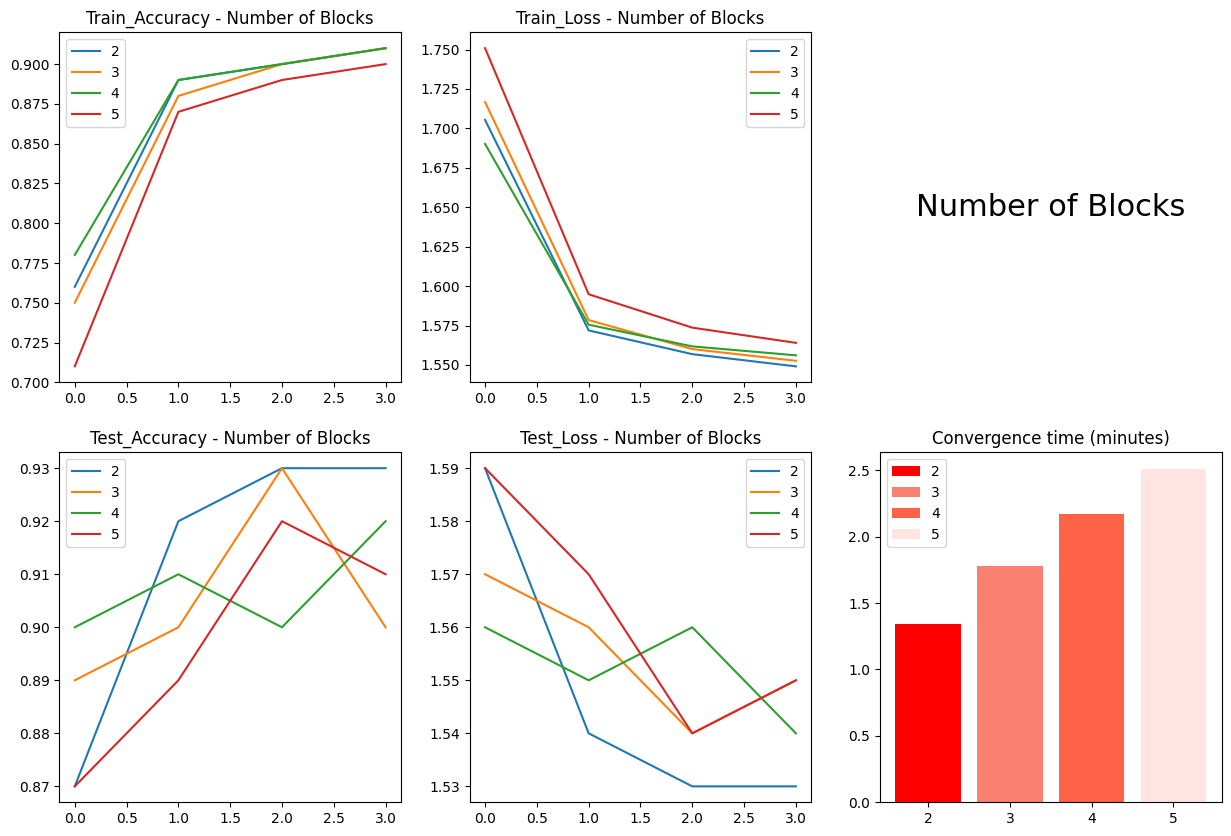

In [21]:
plt.figure(figsize=(15,10))

plt.subplot(231)
for i in range(len(liste_nb_blocks)):
  plt.plot(range(epochs),train_per_model[i][0],label=liste_nb_blocks[i])

plt.title("Train_Accuracy - Number of Blocks")
plt.legend()

plt.subplot(232)
for i in range(len(liste_nb_blocks)):
  plt.plot(range(epochs),train_per_model[i][1],label=liste_nb_blocks[i])

plt.title("Train_Loss - Number of Blocks")
plt.legend()

plt.subplot(233)
plt.axis('off')
plt.text(0.5, 0.5,'Number of Blocks', ha='center', va='center', fontsize=22, color='black')

plt.subplot(234)
for i in range(len(liste_nb_blocks)):
  plt.plot(range(epochs),test_per_model[i][0],label=liste_nb_blocks[i])

plt.title("Test_Accuracy - Number of Blocks")
plt.legend()

plt.subplot(235)
for i in range(len(liste_nb_blocks)):
  plt.plot(range(epochs),test_per_model[i][1],label=liste_nb_blocks[i])

plt.title("Test_Loss - Number of Blocks")
plt.legend()

plt.subplot(236)
plt.title("Convergence time (minutes)")
plt.bar(liste_nb_blocks,time_per_model,label=liste_nb_blocks,color=['red','salmon','tomato','mistyrose'])
plt.legend()


plt.savefig('nb_blocks.png', dpi=300)
plt.show()

# Q8: larger transformers

Try to use bigger transformer, for example the ViT-S from the timm library. Test with and without intialization from imagenet.

In [28]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.6 MB/s eta 0:00:00


a) Load the model using the timm library without pretrained wewights. Try to apply it directly on a tensor with the same MNIST images resolution. What it is the problem and why we have it? Explain if we have also such problem with CNNs. As ViT takes RGB images, the input tensor should have 3 channels.

### Response
The problem you're encountering when trying to apply a pre-trained ViT model to a tensor with the same resolution as MNIST images (28x28 pixels) is related to the input requirements of the ViT model and the inherent design differences between ViT and Convolutional Neural Networks (CNNs).

Input Channel Mismatch: The ViT model expects input images with 3 color channels (RGB), but MNIST dataset images have only one channel (grayscale). When you apply a pre-trained ViT model directly to MNIST-sized images, it expects three color channels but receives only one, causing a shape mismatch error.

In contrast, CNNs can work directly with single-channel (grayscale) images as long as the input and model architectures are appropriately configured to handle single-channel images. CNNs are more flexible in this regard, as you can easily adapt them to different input channel configurations.

Input Size Mismatch: Pre-trained ViT models, including the 'vit_base_patch16_224' model, are typically designed for larger image resolutions, such as 224x224 pixels. When you attempt to apply the model directly to smaller images like MNIST (28x28 pixels), it may lead to issues because the model's architecture expects a different input size.

CNNs are more robust when it comes to handling various input image sizes. They can adapt to different input sizes, and many CNN architectures are specifically designed to work with small images like those in the MNIST dataset.

To resolve the problem:

You can resize the MNIST images to match the expected input size of the ViT model (e.g., 224x224 pixels) and pad the grayscale image to create three channels. This would require preprocessing the MNIST images to meet the ViT model's input requirements.

Alternatively, you can fine-tune a ViT model on the MNIST dataset with a modified architecture that accepts single-channel images and smaller resolutions. Fine-tuning allows you to adapt a pre-trained model to a specific task and input configuration.

CNNs, on the other hand, can be directly applied to MNIST-sized grayscale images without extensive modifications. They handle input size and channel variations more gracefully.

In [3]:
import timm

# Define the ViT model architecture without pre-trained weights
model = timm.create_model('vit_base_patch16_224', pretrained=False)

model.eval()

input_tensor = torch.randn(32, 1, 224, 224)
output = model(input_tensor)

RuntimeError: ignored

In [4]:
model = timm.create_model('vit_base_patch16_224', pretrained=False)

x = torch.randn(32, 1, 28, 28)

# Expand to 3 channels (convert grayscale to RGB)
x = torch.cat([x] * 3, dim=1)

# Resize the input tensor to the expected size of ViT (224x224 pixels)
x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

model(x).shape

torch.Size([32, 1000])

b) There is a trcik in timm that allows to use pretrained models with different image resolution and number of classes. Try to reload the model to be able to use on MNIST images:

In [5]:
input_resolution = 28
num_classes = 10

# Load the pre-trained ViT model from Timm with adapted settings
model = timm.create_model(
    'vit_base_patch16_224',
    pretrained=True,
    num_classes=num_classes,
    in_chans=3,
    img_size=input_resolution,
)

model(torch.randn(32, 3, 28, 28)).shape

torch.Size([32, 10])

c) redo the training with the pretrained ViT-S





In [6]:
@torch.no_grad()
def eval_model(model, loader, num_channels=1):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x, y

    x = torch.cat([x] * 3, dim=1)
    x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

In [ ]:
import timm

model = timm.create_model('vit_base_patch16_224', pretrained=False)

model.train()

epochs = 10

opt = torch.optim.Adam(model.parameters())

for epoch in tqdm(range(epochs)):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x, y

    opt.zero_grad()
    x = torch.cat([x] * 3, dim=1)
    x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")

acc = eval_model(model, test_loader, num_channels=3)
print(f"Test accuracy: {acc}")

  0%|          | 0/10 [00:00<?, ?it/s]

c) redo the training but with the ViT-S pretrained on ImageNet

In [ ]:
model = timm.create_model(
    'vit_base_patch16_224',
    pretrained=True,
    num_classes=num_classes,
    in_chans=1,
    img_size=input_resolution,
)

In [ ]:
import timm

epochs = 10

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    x = None # adapt number of channels to fit in ViT
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc = eval_model(model, test_loader, num_channels=3)
print(f"Test accuracy: {acc}")

d) Comment the final results and provide some ideas on how to make transformer work on small datasets. You can take inspiration from some recent work.